In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import operator
import math
import warnings
import openpyxl
import random
warnings.filterwarnings('ignore')
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import tensorflow as tf
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import pandas as pd

# 한글 글꼴체 변경
plt.rcParams['font.family'] ='Malgun Gothic'
# df.head() 이런거 했을 때, 컬럼이 생략되지 않고, 모든 컬럼 뜨게
pd.set_option('display.max_columns', None)
# 지수 표기법 대신에 소수점으로 표시하는코드
pd.options.display.float_format = '{:.5f}'.format
# 값 길이 제한 X
pd.set_option('display.max_colwidth', None) # 값 길이 제한 없음

전처리, Feature Selection한 데이터 불러오기

In [3]:
df = pd.read_csv("data/full_data/TPS_cancel_data_Final.csv")

In [4]:
df

,sha2_hash,AGE_GRP10,AGMT_END_SEG,BUNDLE_YN,CH_HH_AVG_MONTH1,CH_LAST_DAYS_BF_GRP,CONTENT_USE_YN,INHOME_RATE,MEDIA_NM_GRP,MONTHS_REMAINING,SCRB_PATH_NM_GRP,STB_RES_1M_YN,SVC_USE_DAYS_GRP,TOTAL_USED_DAYS,TV_I_CNT,VOC_STOP_CANCEL_MONTH1_YN,VOC_TOTAL_MONTH1_YN,p_mt,churn
0,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,60대,약정만료전 12개월이상,Y,0.00000,3개월내없음,N,10.00000,HD,13,I/B,N,12개월~24개월미만,733,3.00000,N,N,2,N
1,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,60대,약정만료전 9~12개월,Y,6.72000,일주일내,N,0.00000,HD,12,I/B,Y,24개월~ 36개월미만,764,3.00000,N,Y,3,N
2,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,60대,약정만료전 9~12개월,Y,9.86000,3주일전,N,10.00000,HD,11,I/B,N,24개월~ 36개월미만,794,3.00000,N,N,4,N
3,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,60대,약정만료전 9~12개월,Y,5.95000,4주일전,N,10.00000,HD,10,I/B,N,24개월~ 36개월미만,825,3.00000,N,N,5,N
4,0000113b86db7c509bbe74d609529031b03b7c033dbdfbd8b7fcecbf92bc8600,60대,약정만료전 6~9개월,Y,4.03000,일주일내,N,0.00000,HD,9,I/B,N,24개월~ 36개월미만,855,3.00000,N,N,6,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21483374,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,50대,약정만료후 12개월이상,N,2.03000,일주일내,N,10.00000,HD,-40,현장경로,N,36개월 이상,2338,1.00000,N,N,8,N
21483375,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,50대,약정만료후 12개월이상,N,2.91000,일주일내,N,10.00000,HD,-41,현장경로,N,36개월 이상,2368,1.00000,N,N,9,N
21483376,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,50대,약정만료후 12개월이상,N,1.97000,2주일전,N,10.00000,HD,-42,현장경로,N,36개월 이상,2399,1.00000,N,Y,10,N
21483377,fffffa7eda8144ce27e65690933ae8994e6962fefd24c982990467add99d61a7,50대,약정만료후 12개월이상,N,0.00000,3개월내없음,N,0.00000,HD,-43,현장경로,N,36개월 이상,2429,1.00000,N,N,11,N


LightGBM 학습

In [5]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler

# -----------------------------------------------------------
# 1️⃣ 데이터 분할 (p_mt 기준)
# -----------------------------------------------------------
train = df[df['p_mt'].isin([2,3,4,5,6,7,8,9])].drop(columns=['sha2_hash', 'p_mt'])
val = df[df['p_mt'] == 10].drop(columns=['sha2_hash', 'p_mt'])
test = df[df['p_mt'] == 11].drop(columns=['sha2_hash', 'p_mt'])

# -----------------------------------------------------------
# 2️⃣ 랜덤 언더샘플링 적용 (Train 데이터만)
# -----------------------------------------------------------
X = train.drop(columns=['churn'])
y = train['churn']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

# 샘플링 후 데이터 병합
y_resampled = pd.Series(y_resampled, name='churn')
train = pd.concat([X_resampled, y_resampled], axis=1)

# 샘플링 후 데이터 분포 확인
print("✅ 랜덤 언더샘플링 완료!")
print(y_resampled.value_counts())

# -----------------------------------------------------------
# 3️⃣ INHOME_RATE 컬럼을 object(string) 타입으로 변환
# -----------------------------------------------------------
train['INHOME_RATE'] = train['INHOME_RATE'].astype(str)
val['INHOME_RATE'] = val['INHOME_RATE'].astype(str)
test['INHOME_RATE'] = test['INHOME_RATE'].astype(str)

print(f"train INHOME_RATE dtype: {train['INHOME_RATE'].dtype}")
print(f"val INHOME_RATE dtype: {val['INHOME_RATE'].dtype}")
print(f"test INHOME_RATE dtype: {test['INHOME_RATE'].dtype}")

# -----------------------------------------------------------
# 4️⃣ 레이블 인코딩 (범주형 변수)
# -----------------------------------------------------------
train_val_test = pd.concat([train, val, test])

categorical_cols = train_val_test.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    train_val_test[col] = le.fit_transform(train_val_test[col])
    label_encoders[col] = le

# 인코딩 후 다시 train, val, test로 분리
train = train_val_test.iloc[:len(train)].reset_index(drop=True)
val = train_val_test.iloc[len(train):len(train) + len(val)].reset_index(drop=True)
test = train_val_test.iloc[len(train) + len(val):].reset_index(drop=True)

print("✅ 레이블 인코딩 완료!")

# 레이블 인코딩 매핑 출력
for col, le in label_encoders.items():
    print(f"🔹 {col} 레이블 인코딩 매핑:")
    print(dict(zip(le.classes_, le.transform(le.classes_))))
    print("-" * 30)

# -----------------------------------------------------------
# 5️⃣ 데이터 스케일링 (RobustScaler + MinMaxScaler)
# -----------------------------------------------------------
robust_columns = ['TOTAL_USED_DAYS', 'CH_HH_AVG_MONTH1', 'MONTHS_REMAINING']  # RobustScaler 적용
minmax_columns = [col for col in train.columns if col not in robust_columns + ['churn']]  # 나머지는 MinMaxScaler 적용

# 스케일러 생성
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

# RobustScaler 적용
train[robust_columns] = robust_scaler.fit_transform(train[robust_columns])
val[robust_columns] = robust_scaler.transform(val[robust_columns])
test[robust_columns] = robust_scaler.transform(test[robust_columns])

# MinMaxScaler 적용
train[minmax_columns] = minmax_scaler.fit_transform(train[minmax_columns])
val[minmax_columns] = minmax_scaler.transform(val[minmax_columns])
test[minmax_columns] = minmax_scaler.transform(test[minmax_columns])

print("✅ Robust & MinMax Scaling 완료!")

✅ 랜덤 언더샘플링 완료!
churn
N    105706
Y    105706
Name: count, dtype: int64
train INHOME_RATE dtype: object
val INHOME_RATE dtype: object
test INHOME_RATE dtype: object
✅ 레이블 인코딩 완료!
🔹 AGE_GRP10 레이블 인코딩 매핑:
{'10대': 0, '20대': 1, '30대': 2, '40대': 3, '50대': 4, '60대': 5, '70대': 6, '80대': 7, '90대이상': 8, '연령없음': 9}
------------------------------
🔹 AGMT_END_SEG 레이블 인코딩 매핑:
{'약정만료 1개월': 0, '약정만료전 12개월이상': 1, '약정만료전 1~2개월': 2, '약정만료전 1개월': 3, '약정만료전 2~3개월': 4, '약정만료전 3~6개월': 5, '약정만료전 6~9개월': 6, '약정만료전 9~12개월': 7, '약정만료후 12개월이상': 8, '약정만료후 1개월~2개월': 9, '약정만료후 2개월~3개월': 10, '약정만료후 3~6개월': 11, '약정만료후 6~9개월': 12, '약정만료후 9~12개월': 13}
------------------------------
🔹 BUNDLE_YN 레이블 인코딩 매핑:
{'N': 0, 'Y': 1}
------------------------------
🔹 CH_LAST_DAYS_BF_GRP 레이블 인코딩 매핑:
{'2주일전': 0, '3개월내없음': 1, '3주일전': 2, '4주일전': 3, '일주일내': 4, '일주일전': 5}
------------------------------
🔹 CONTENT_USE_YN 레이블 인코딩 매핑:
{'N': 0, 'Y': 1}
------------------------------
🔹 INHOME_RATE 레이블 인코딩 매핑:
{'0.0': 0, '10.0': 1, '100.0': 2, '2

In [6]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators=48,
    max_depth=-1,
    learning_rate=0.1,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(n_estimators=48, random_state=42)

Validation Accuracy: 0.80

Classification Report (Validation):
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1934325
           1       0.03      0.73      0.05     14325

    accuracy                           0.80   1948650
   macro avg       0.51      0.77      0.47   1948650
weighted avg       0.99      0.80      0.88   1948650


Confusion Matrix (Validation):
[[1554791  379534]
 [   3851   10474]]


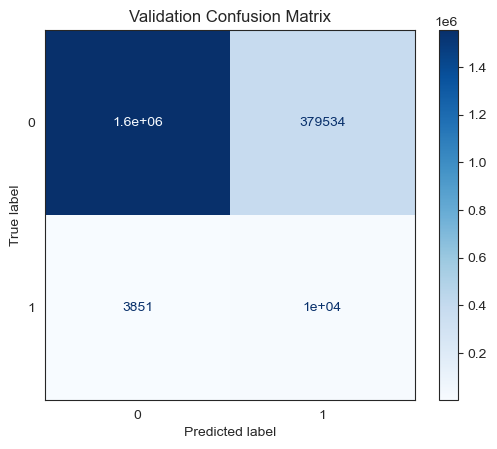

Validation AUC-ROC: 0.85


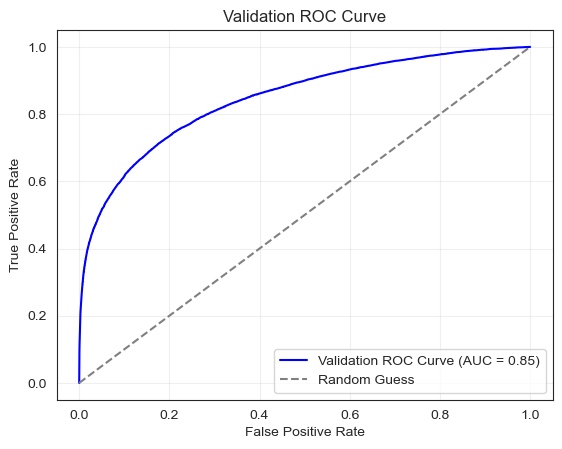

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 초기화
sns.set_style("white")

# 검증 데이터
X_val = val.drop(columns=['churn'])
y_val = val['churn']

# -----------------------------------------------------------
# 검증 데이터 (Validation) 평가
# -----------------------------------------------------------
# 검증 데이터(val) 예측
val_predictions = lgbm_model.predict(X_val)

# 정확도 확인
val_accuracy = accuracy_score(y_val, val_predictions)
print(f"Validation Accuracy: {val_accuracy:.2f}")

# Classification Report
print("\nClassification Report (Validation):")
print(classification_report(y_val, val_predictions))

# Confusion Matrix
print("\nConfusion Matrix (Validation):")
conf_matrix = confusion_matrix(y_val, val_predictions)
print(conf_matrix)
disp_val = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=lgbm_model.classes_)
disp_val.plot(cmap="Blues")
plt.title("Validation Confusion Matrix")
plt.show()

# -----------------------------------------------------------
# AUC-ROC 계산 및 시각화
# -----------------------------------------------------------
val_probabilities = lgbm_model.predict_proba(X_val)[:, 1]  # 클래스 1에 대한 확률
val_auc = roc_auc_score(y_val, val_probabilities)
print(f"Validation AUC-ROC: {val_auc:.2f}")

# ROC Curve 계산
fpr_val, tpr_val, thresholds_val = roc_curve(y_val, val_probabilities)

# ROC Curve 시각화
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Validation ROC Curve (AUC = {val_auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Validation ROC Curve")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932416
           1       0.03      0.74      0.05     13176

    accuracy                           0.81   1945592
   macro avg       0.51      0.77      0.47   1945592
weighted avg       0.99      0.81      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1559682  372734]
 [   3426    9750]]


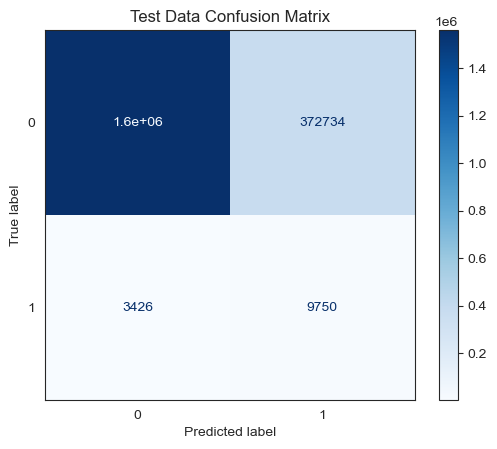

Test AUC-ROC: 0.85


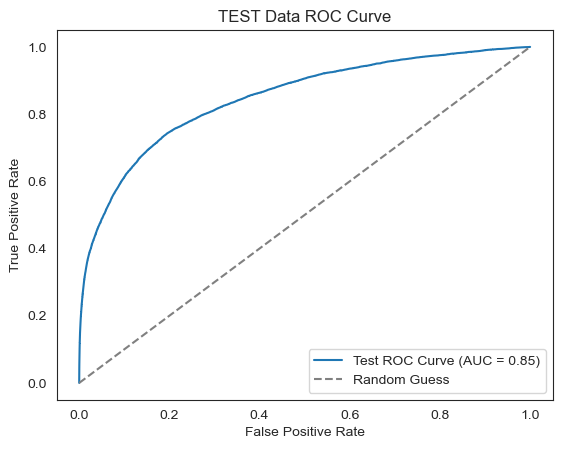

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

하이퍼 파라미터 튜닝을 진행해보자. with Optuna

#### 📌 Optuna란?

##### 🔹 Optuna 개요
**Optuna**는 **자동화된 하이퍼파라미터 최적화 라이브러리**로,   
머신러닝 모델의 **최적 하이퍼파라미터 조합을 찾는 과정**을 자동으로 수행합니다.

##### 🔹 Optuna의 특징
- ✅ **자동 탐색**: 주어진 범위에서 최적의 하이퍼파라미터를 찾음
- ✅ **베이지안 최적화 지원**: 효율적인 탐색을 수행
- ✅ **Pruning 기능**: 성능이 낮은 모델을 조기 종료하여 시간 절약
- ✅ **병렬 실행 가능**: 여러 개의 탐색(trial)을 동시에 실행 가능

---

In [9]:
display(train,val,test)

,AGE_GRP10,AGMT_END_SEG,BUNDLE_YN,CH_HH_AVG_MONTH1,CH_LAST_DAYS_BF_GRP,CONTENT_USE_YN,INHOME_RATE,MEDIA_NM_GRP,MONTHS_REMAINING,SCRB_PATH_NM_GRP,STB_RES_1M_YN,SVC_USE_DAYS_GRP,TOTAL_USED_DAYS,TV_I_CNT,VOC_STOP_CANCEL_MONTH1_YN,VOC_TOTAL_MONTH1_YN,churn
0,0.50000,0.07692,1.00000,0.52131,0.80000,0.00000,0.40000,0.00000,0.28070,0.11111,0.00000,0.50000,0.08521,0.40000,0.00000,0.00000,0
1,0.12500,0.61538,1.00000,1.27213,0.80000,1.00000,0.60000,0.50000,-0.71930,0.44444,0.00000,0.75000,-0.15840,0.20000,0.00000,0.00000,0
2,0.50000,0.07692,0.00000,1.24098,0.80000,0.00000,0.70000,0.00000,0.47368,0.00000,0.00000,0.75000,0.21754,0.20000,0.00000,0.00000,0
3,0.37500,0.07692,1.00000,-0.10164,0.80000,0.00000,0.10000,0.00000,0.33333,0.44444,0.00000,0.50000,0.58396,0.20000,0.00000,0.00000,0
4,0.87500,0.07692,1.00000,-0.39016,0.40000,0.00000,0.00000,0.00000,0.31579,0.11111,0.00000,0.00000,0.64411,0.40000,0.00000,1.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211407,0.50000,0.07692,1.00000,-0.13279,0.80000,0.00000,0.00000,0.00000,0.50877,0.44444,1.00000,0.50000,0.53634,0.20000,0.00000,0.00000,1
211408,0.12500,0.07692,1.00000,-0.44426,0.20000,0.00000,0.00000,0.00000,0.33333,0.11111,1.00000,0.00000,-1.07318,0.20000,0.00000,0.00000,1
211409,0.37500,0.07692,1.00000,0.12787,0.80000,1.00000,0.00000,0.50000,0.61404,1.00000,1.00000,1.00000,-1.31880,0.20000,0.00000,1.00000,1
211410,0.37500,0.07692,0.00000,-0.34262,1.00000,0.00000,0.00000,0.00000,0.49123,1.00000,0.00000,0.75000,-1.20852,0.00000,0.00000,0.00000,1


,AGE_GRP10,AGMT_END_SEG,BUNDLE_YN,CH_HH_AVG_MONTH1,CH_LAST_DAYS_BF_GRP,CONTENT_USE_YN,INHOME_RATE,MEDIA_NM_GRP,MONTHS_REMAINING,SCRB_PATH_NM_GRP,STB_RES_1M_YN,SVC_USE_DAYS_GRP,TOTAL_USED_DAYS,TV_I_CNT,VOC_STOP_CANCEL_MONTH1_YN,VOC_TOTAL_MONTH1_YN,churn
0,0.50000,0.07692,1.00000,0.15574,0.80000,0.00000,0.30000,0.00000,0.57895,0.00000,0.00000,0.25000,-0.83409,0.40000,0.00000,0.00000,0
1,0.37500,0.46154,1.00000,2.50164,0.80000,0.00000,0.90000,0.00000,0.12281,0.00000,0.00000,0.25000,0.86717,0.20000,0.00000,1.00000,0
2,0.50000,0.07692,1.00000,-0.08197,0.80000,0.00000,0.10000,0.00000,0.35088,0.44444,0.00000,0.50000,-0.01554,1.00000,0.00000,0.00000,0
3,0.50000,1.00000,0.00000,-0.07869,0.80000,0.00000,0.10000,0.00000,-0.17544,0.44444,0.00000,0.50000,-0.34236,0.40000,0.00000,0.00000,0
4,0.37500,0.61538,1.00000,-0.03443,0.80000,0.00000,0.00000,0.00000,-0.89474,1.00000,0.00000,0.50000,0.65514,0.60000,0.00000,0.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1948645,0.37500,0.61538,0.00000,-0.20328,0.60000,0.00000,0.00000,0.00000,-0.84211,1.00000,0.00000,0.50000,0.46466,0.20000,0.00000,0.00000,0
1948646,0.25000,0.61538,1.00000,-0.13770,0.80000,0.00000,0.10000,0.00000,-0.68421,0.11111,0.00000,0.50000,-0.19599,0.40000,0.00000,0.00000,0
1948647,0.12500,0.61538,0.00000,0.11639,1.00000,0.00000,0.00000,0.00000,-1.91228,0.44444,0.00000,0.00000,0.64461,0.20000,0.00000,0.00000,0
1948648,0.37500,0.07692,1.00000,0.21803,0.80000,0.00000,0.30000,0.50000,0.33333,0.00000,0.00000,0.50000,-0.56140,0.20000,0.00000,1.00000,0


,AGE_GRP10,AGMT_END_SEG,BUNDLE_YN,CH_HH_AVG_MONTH1,CH_LAST_DAYS_BF_GRP,CONTENT_USE_YN,INHOME_RATE,MEDIA_NM_GRP,MONTHS_REMAINING,SCRB_PATH_NM_GRP,STB_RES_1M_YN,SVC_USE_DAYS_GRP,TOTAL_USED_DAYS,TV_I_CNT,VOC_STOP_CANCEL_MONTH1_YN,VOC_TOTAL_MONTH1_YN,churn
0,0.50000,0.07692,1.00000,0.57705,0.80000,0.00000,0.30000,0.00000,0.56140,0.00000,0.00000,0.25000,-0.81905,0.40000,0.00000,0.00000,0
1,0.37500,0.46154,1.00000,2.07541,0.80000,0.00000,0.80000,0.00000,0.10526,0.00000,0.00000,0.25000,0.88221,0.20000,0.00000,0.00000,0
2,0.50000,0.07692,1.00000,-0.20328,0.80000,0.00000,0.10000,0.00000,0.33333,0.44444,0.00000,0.50000,-0.00050,1.00000,0.00000,0.00000,0
3,0.50000,1.00000,0.00000,-0.09016,0.80000,0.00000,0.10000,0.00000,-0.19298,0.44444,0.00000,0.50000,-0.32732,0.40000,0.00000,0.00000,0
4,0.37500,0.61538,1.00000,-0.17541,0.80000,0.00000,0.00000,0.00000,-0.91228,1.00000,0.00000,0.50000,0.67018,0.60000,0.00000,1.00000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945587,0.37500,0.61538,0.00000,-0.44426,0.20000,0.00000,0.00000,0.00000,-0.85965,1.00000,0.00000,0.50000,0.47970,0.20000,0.00000,0.00000,0
1945588,0.25000,0.61538,1.00000,-0.14754,0.80000,0.00000,0.10000,0.00000,-0.70175,0.11111,0.00000,0.50000,-0.18095,0.40000,0.00000,0.00000,0
1945589,0.12500,0.61538,0.00000,-0.16721,0.80000,0.00000,0.00000,0.00000,-1.92982,0.44444,0.00000,0.00000,0.65965,0.20000,0.00000,0.00000,0
1945590,0.37500,0.07692,1.00000,0.11148,0.80000,0.00000,0.30000,0.50000,0.31579,0.00000,0.00000,0.50000,-0.54637,0.20000,0.00000,0.00000,0


Optuna도 코랩에서 진행

In [ ]:
# 코랩 코드

import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score

X_train = train.drop(columns=['churn'])
y_train = train['churn']
X_val = val.drop(columns=['churn'])
y_val = val['churn']

def objective(trial):
    param = { # 하이퍼파라미터 탐색 공간 정의
        'n_estimators': trial.suggest_int('n_estimators', 30, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 200),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 10.0)
    }

    # ✅ LightGBM 모델 생성
    model = LGBMClassifier(**param, random_state=42)

    # ✅ 모델 학습
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        early_stopping_rounds=30,
        verbose=False
    )

    # ✅ 검증 데이터 예측
    val_predictions = model.predict(X_val)
    val_probabilities = model.predict_proba(X_val)[:, 1]

    # ✅ 혼동 행렬 계산
    cm = confusion_matrix(y_val, val_predictions)
    tn, fp, fn, tp = cm.ravel()

    # ✅ 성능 지표 계산
    f1 = f1_score(y_val, val_predictions)
    roc_auc = roc_auc_score(y_val, val_probabilities)

    # ✅ 지표 기반 조건 설정 (FN 최소화, TP 증가, FP 감소, TN 증가)
    if fn > 5000:
        return 0
    if tp < 9000:
        return 0

    return roc_auc + (tp / (tp + fn))

# ✅ Optuna 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# ✅ 최적의 하이퍼파라미터 출력
print("Best Parameters:", study.best_params)
print("Best Score (ROC-AUC + TP 비율):", study.best_value)

코드를 실행하게 되면 밑에 첨부한 이미지처럼 자동으로 하이퍼파라미터를 찾게 된다.

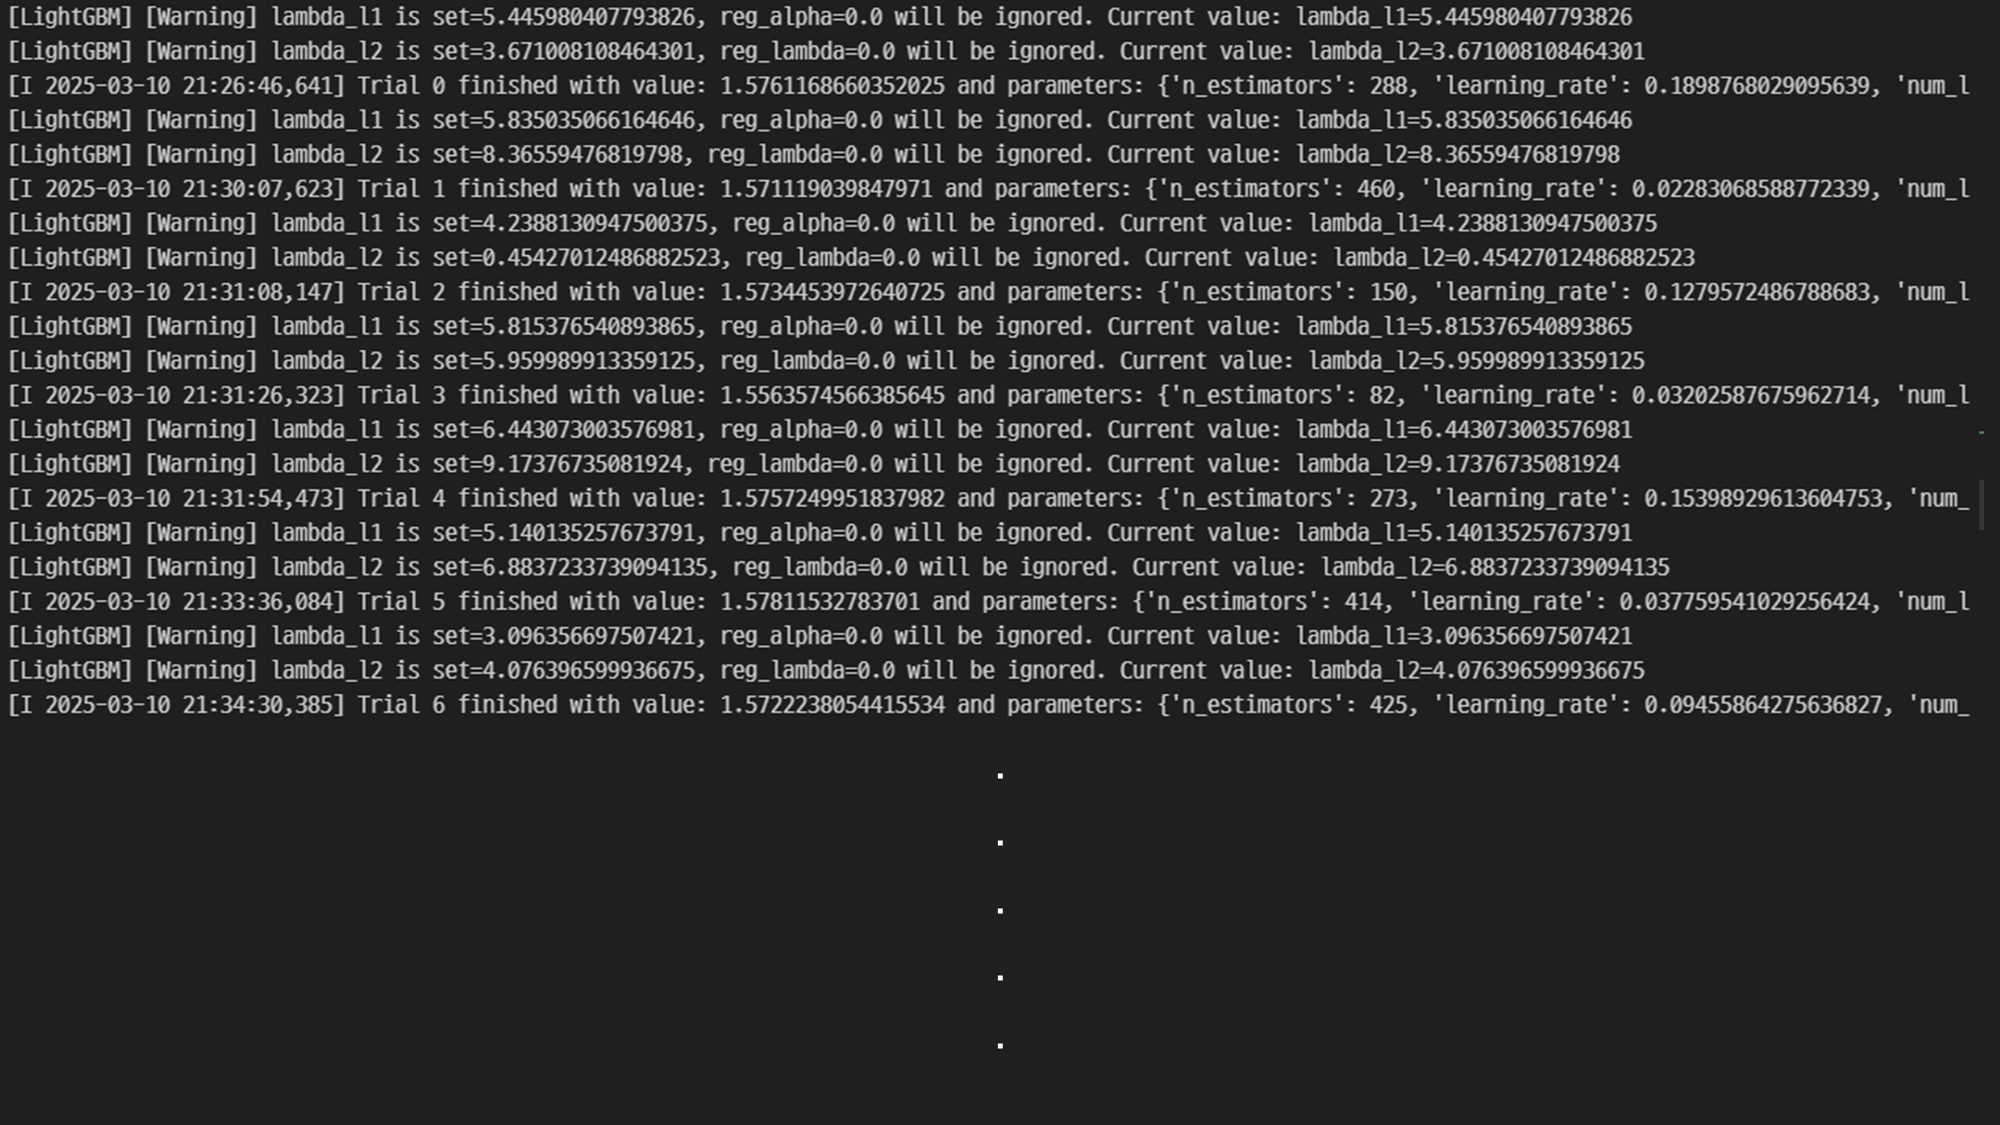

내가 찾은 Best 파라미터는

### 해당 파라미터들이다! ✅

| **하이퍼파라미터**       | **최적 값**         |
|------------------|------------------------|
| `n_estimators`   | 52                      |
| `learning_rate`  | 0.06162796790008785     |
| `num_leaves`     | 44                      |
| `max_depth`      | 31                      |
| `min_child_samples` | 125                  |
| `subsample`      | 0.8450232368747989      |
| `colsample_bytree` | 0.6016815309534599    |
| `lambda_l1`      | 2.8300118312412064      |
| `lambda_l2`      | 9.81537138062259        |


Optuna로 설정된 Best 파라미터로 LGBM 모델링 수행

In [58]:
from lightgbm import LGBMClassifier

# 독립 변수 & 종속 변수 설정
X_train = train.drop(columns=['churn'])  # 독립 변수
y_train = train['churn']  # 종속 변수

# LightGBM 모델 생성
lgbm_model = LGBMClassifier(
    n_estimators= 52,
    max_depth = 31,
    learning_rate=0.06162796790008785,
    num_leaves = 44,
    min_child_samples = 125,
    subsample = 0.8450232368747989,
    colsample_bytree = 0.6016815309534599,
    lambda_l1 = 2.8300118312412064,
    lambda_l2 = 9.81537138062259,
    random_state=42 
)

# 모델 학습
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.6016815309534599,
               lambda_l1=2.8300118312412064, lambda_l2=9.81537138062259,
               learning_rate=0.06162796790008785, max_depth=31,
               min_child_samples=125, n_estimators=52, num_leaves=44,
               random_state=42, subsample=0.8450232368747989)

Test Accuracy: 0.81

Classification Report (테스트 데이터):
              precision    recall  f1-score   support

           0       1.00      0.81      0.89   1932416
           1       0.03      0.74      0.05     13176

    accuracy                           0.81   1945592
   macro avg       0.51      0.77      0.47   1945592
weighted avg       0.99      0.81      0.89   1945592


Confusion Matrix (테스트 데이터):
[[1557375  375041]
 [   3414    9762]]


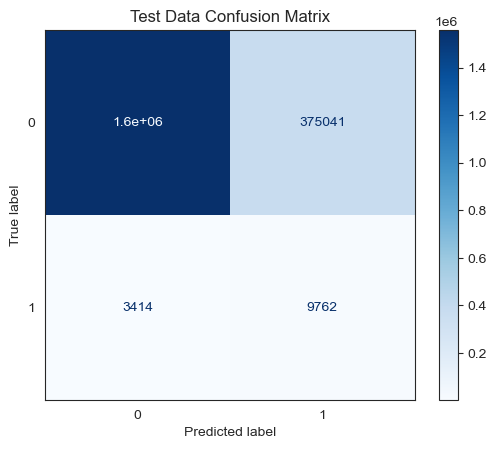

Test AUC-ROC: 0.85


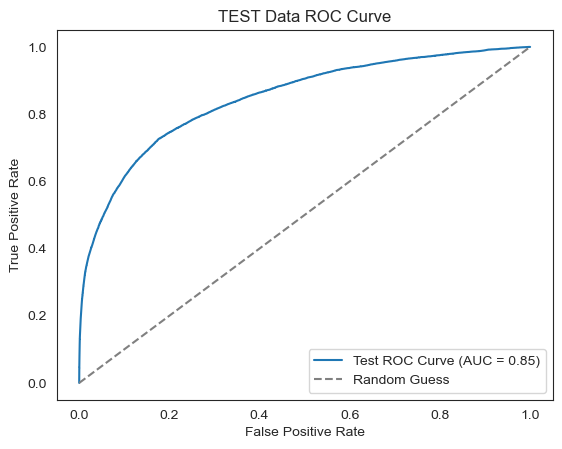

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay  # ConfusionMatrixDisplay 임포트
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

# 테스트 데이터 불러오기
X_test = test.drop(columns=['churn'])
y_test = test['churn']

# -----------------------------------------------------------
# 테스트 데이터 (Test) 평가
# -----------------------------------------------------------
# 테스트 데이터(test) 예측
test_predictions = lgbm_model.predict(X_test)

# 정확도 확인
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification 리포트
print("\nClassification Report (테스트 데이터):")
print(classification_report(y_test, test_predictions))

# Confusion Matrix (혼동행렬)
print("\nConfusion Matrix (테스트 데이터):")
print(confusion_matrix(y_test, test_predictions))
disp_test = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=lgbm_model.classes_)

plt.figure()
disp_test.plot(cmap="Blues", ax=plt.gca())
plt.grid(False)
plt.title("Test Data Confusion Matrix")
plt.show()

# AUC-ROC 계산
test_probabilities = lgbm_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probabilities)
print(f"Test AUC-ROC: {test_auc:.2f}")

# ROC Curve 시각화
fpr_val, tpr_val, thresholds_val = roc_curve(y_test, test_probabilities)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f"Test ROC Curve (AUC = {test_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST Data ROC Curve")
plt.legend()
plt.grid(False)
plt.show()

### FP 값을 희생하고, FN의 값을 소폭(-12) 줄이고, TP의 값을 소폭 증가(+12) 시켰음.

#### 📌 Optuna Best Parameters (LightGBM)

Optuna를 사용하여 찾은 LightGBM 모델의 최적 하이퍼파라미터

##### 🔹 최적의 하이퍼파라미터 값
| **하이퍼파라미터**       | **최적 값**         |
|------------------|------------------------|
| `n_estimators`   | 52                      |
| `learning_rate`  | 0.06162796790008785     |
| `num_leaves`     | 44                      |
| `max_depth`      | 31                      |
| `min_child_samples` | 125                  |
| `subsample`      | 0.8450232368747989      |
| `colsample_bytree` | 0.6016815309534599    |
| `lambda_l1`      | 2.8300118312412064      |
| `lambda_l2`      | 9.81537138062259        |